# Building Neural Networks

### Contents
    1. Introduction
    2. MNIST Dataset
    3. Define your own Neural Network
    4. Train the Model
    5. Test the Model
    6. Demonstrate the Model
    7. Save the Model

## 1. Introduction
A neural network is a network composed of artificial neurons and nodes, being modeled after the human brain architecture and activation processes. It is mainly used to solve problems of artificial intelligence problems. <br/>

<br> The below diagram describes a brief process of neural network. Inputs are multiplied by weights, and summed, and it is passed to activation function, which converts the output to a value in a specific range, -1 to 1 or 0 to 1.

<img src = "./Images/DNN.png">

There are variations of the neural network, including fully connected networks, convolutional neural networks, recurrent neural networks, that works in different areas. <br/>
<br> **Fully-connected networks**, or deep neural networks, is comprised of linear networks. <br/>
<br> **Convolutional Neural Networks (CNN)** is typically made up of convolutional layers, pooling layers, and fully-connected layers. It effectively extracts useful features from visual data, thus it is widely used in the field of visual tasks. <br/>
<br> **Recurrent Neural Networks (RNN)** save all the pre-processed information so as to reuse it in the future, thus effective in dealing with natural language and time-series data.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import helper
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(torch.__version__)

1.5.1+cpu


Setting device on GPU if available, else CPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 1. MNIST Dataset

A neural network introduced for this tutorial is for **digit classification** using `MNIST(Modified National Institute of Standard and Technology database)`. <br/>
<br> It is a large database of handwritten digits and most widely used dataset for training and testing neural networks and for beginners. It contains 60,000 training images and 10,000 testing images and each image has a size of 28 * 28 (= 784) and is a binary image (black and white or 1-color channel). 

In [4]:
# define a transform to normalize the data

transform = transforms.Compose([
    transforms.ToTensor(), # ToTensor() must be declared before Normalize()
                           # It converts the range from [0, 255] to [0, 1]
    transforms.Normalize(mean = (0.5, ), std = (0.5, ))
    # mean: (m1, m2, ..., mn) and std: (s1, s2, ..., sn)
])

In [5]:
# batch_size is the number of training examples in one forward and backward pass.
# As the computer is a binary machine, the magnitude of batch size is recommended to set powers of two (2^n). 

batch_size = 64

# download and load the train data
train_data = datasets.MNIST('./data/MNIST', 
                            download = True, 
                            train = True, 
                            transform = transform)
train_loader = DataLoader(train_data, 
                          batch_size = batch_size, 
                          shuffle = True)

# download and load the test data
test_data = datasets.MNIST('./data/MNIST', 
                           download = True, # already downloaded so don't have to declare again
                           train = False, 
                           transform = transform)

test_loader = DataLoader(test_data, 
                         batch_size = batch_size, 
                         shuffle = False)

In [6]:
train_data.data.size(), test_data.data.size()

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

To check the data, the below code shows the random data within training dataset.

Target: 7
Size of Image: (28, 28)


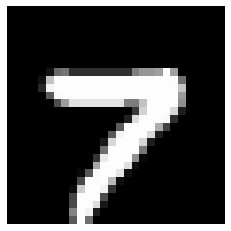

In [7]:
idx = torch.randint(0, len(train_data), (1, )).item()
random_image = train_data[idx][0].squeeze().numpy()
target_num = train_data[idx][1]
print("Target: {}".format(target_num))
print("Size of Image: {}".format(random_image.shape))
plt.imshow(random_image, cmap = "gray")
plt.axis("off")
plt.show()

## 2. Define your own Neural Network

<img src = "./Images/MNIST_Network.png" align = "left">

<br> [Image source](http://neuralnetworksanddeeplearning.com/chap1.html) </br>

Let's build a neural network that classifies this dataset with PyTorch. Its input should be 784 (= 28 * 28) and output 10. The figure above is for simple reference, hence does not match to the network built below. More layers or deep learning techniques can be added to increase the accuracy. <br/>
<br> `nn.Sequential` is a 'sequential' container that includes `nn.Linear`, `nn.Conv2D`, and `nn.ReLU`. It processes in the order of methods that the user put on. <br/>
<br> `forward` function processes the functions declared in `__init__`. Read the below code for better understanding.

In [8]:
# define hyper-parameters

input_size = 28 * 28 #(= 784)
hidden_size = [512, 256, 64] # multi-layer perceptron
num_classes = 10
learning_rate = 0.001

In [9]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Model, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.ReLU(),
            
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.ReLU(),
            
            nn.Linear(hidden_size[2], num_classes)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [10]:
model = Model(input_size, hidden_size, num_classes)

In [11]:
print(model.to(device))

Model(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


For training, objective funciton and optimizer are required. Objective function calculates the difference between the answer the output from the model. Optimizer updates the weight to derive outputs closer to answers during back propagation.<br/>
<br> `torch.nn.CrossEntropyLoss` is used especially when solving classification problems.
<br> `torch.optim.Adam` optimizer is used as it shows the best performance so far.

In [12]:
# Loss Function and Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# train list
train_cost = []

## 3. Train the Model

The designed neural network should be trained using MNIST dataset to achieve its original goal, derivation of desired output on un-seen data. The below diagram illustrates the brief overview of training of neural networks.

<img src = './images/TrainingNN.png'>

The input is fed into the neural networks. The, it outputs a prediction and it is compared with true targets using loss function. Then, the optimizer updates the weights of the network using the loss value.

In addition, `num_epochs` is total number of epochs. 
<br> `model.train()` makes model to be train mode.

In [13]:
def train(model, num_epochs):
    model.train()
    
    for epoch in range(num_epochs):
        total_batch = len(train_data) // batch_size
    
        for i, (batch_images, batch_labels) in enumerate(train_loader):
        
            X = batch_images.view(-1, 28 * 28)
            Y = batch_labels
            
            #######################################################################
            ### The below five or six lines should be memorized for further use.###
            
            # forward pass
            pred = model(X)
            # calculation of loss value
            cost = criterion(pred, Y)
            # Adding cost value to the cost_losses class for graph plot later.
            train_cost.append(cost.item())
            
            ## backward pass and optimization
            # gradient initialization
            optimizer.zero_grad()
            # backward pass
            cost.backward()
            # parameter update
            optimizer.step()
            
            #######################################################################
        
            # print statistics of training process
            if (i+1) % 300 == 0:
                print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                     %(epoch+1, num_epochs, i+1, total_batch, np.mean(train_cost)))
    
    # Save the model weights for future inference
    torch.save(model.state_dict(), './data/Tutorial_2_BasicNN.pkl')
    
    print("Learning Finished!")

In [14]:
train(model = model, num_epochs = 7)

Epoch [1/7], lter [300/937], Loss: 0.5591
Epoch [1/7], lter [600/937], Loss: 0.4048
Epoch [1/7], lter [900/937], Loss: 0.3391
Epoch [2/7], lter [300/937], Loss: 0.2907
Epoch [2/7], lter [600/937], Loss: 0.2622
Epoch [2/7], lter [900/937], Loss: 0.2408
Epoch [3/7], lter [300/937], Loss: 0.2210
Epoch [3/7], lter [600/937], Loss: 0.2066
Epoch [3/7], lter [900/937], Loss: 0.1958
Epoch [4/7], lter [300/937], Loss: 0.1838
Epoch [4/7], lter [600/937], Loss: 0.1759
Epoch [4/7], lter [900/937], Loss: 0.1687
Epoch [5/7], lter [300/937], Loss: 0.1610
Epoch [5/7], lter [600/937], Loss: 0.1552
Epoch [5/7], lter [900/937], Loss: 0.1499
Epoch [6/7], lter [300/937], Loss: 0.1443
Epoch [6/7], lter [600/937], Loss: 0.1399
Epoch [6/7], lter [900/937], Loss: 0.1356
Epoch [7/7], lter [300/937], Loss: 0.1310
Epoch [7/7], lter [600/937], Loss: 0.1274
Epoch [7/7], lter [900/937], Loss: 0.1243
Learning Finished!


Addition of more deep learning techniques should improve the model performance.

## 4. Test the Model

After training the model, we should evaluate the model using unseen data. First, use `load_state_dict(torch.load()` to load the saved model weights. Then, run `model.eval()` to set the model to evaluation mode. It turns off any drop-out or batch normalization layers in the model that are not desriable to be used during the test. Also, `torch.no_grad()` disables autograd function. 

In [15]:
model = Model(input_size, hidden_size, num_classes).to(device)
model.load_state_dict(torch.load('./data/Tutorial_2_BasicNN.pkl'))
model.eval()

Model(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [16]:
def test(model):
    
    # declare that the model is about to evaluate
    model.eval()

    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_data:
            images = images.view(-1, 28 * 28).to(device)
            
            # forward pass
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += 1
            correct += (predicted == labels).sum().item()

    print("Accuracy of Test Images: %f %%" % (100 * float(correct) / total))

In [17]:
test(model = model)

Accuracy of Test Images: 97.250000 %


## 5. Demonstrate the Model
It imports an image from test dataset and see if the learning is conducted properly or not.

In [18]:
r = random.randint(0, len(test_data)-1)
X_single_data = Variable(test_data.test_data[r:r + 1].view(-1,28*28).float())
Y_single_data = Variable(test_data.test_labels[r:r + 1])

Label:  [1]
Prediction:  [1]


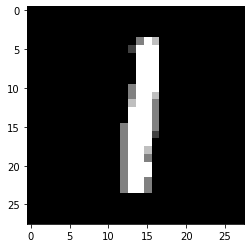

In [19]:
single_prediction = model(X_single_data)
plt.imshow(X_single_data.data.view(28, 28).numpy(), cmap='gray')

print('Label: ', Y_single_data.data.view(1).numpy())
print('Prediction: ', torch.max(single_prediction.data, 1)[1].numpy())